In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import re

## Data Processing

In [2]:
full = pd.read_csv("Data/full_data.csv")
full.head()

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr    FTr  \
0  Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005  0.250   
1            Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009  0.421   
2         Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431  0.363   
3           Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088  0.202   
4           Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053  0.105   

   ...  All_NBA_Pos  All_NBA_Team  All_NBA_Pts_Won  All_NBA_Pts_Max  \
0  ...          NaN           NaN              NaN              NaN   
1  ...          NaN           NaN              NaN              NaN   
2  ...          NaN           NaN              NaN              NaN   
3  ...          NaN           NaN              NaN              NaN   
4  ...          NaN           NaN              NaN              NaN   

   All_NBA_Share  All_NBA_1st_Team_Votes  All_NBA_2nd_Team_Votes  \
0            NaN                     NaN                     NaN   
1            NaN                     NaN                     NaN   
2            NaN                     NaN                     NaN   
3            NaN                     NaN                     NaN   
4            NaN                     NaN                     NaN   

   All_NBA_3rd_Team_Votes       year  All_NBA_Boolean  
0                     NaN  1988-1989            False  
1                     NaN  1988-1989            False  
2                     NaN  1988-1989            False  
3                     NaN  1988-1989            False  
4                     NaN  1988-1989            False  

[5 rows x 37 columns]

We will need to remove the following columns because they are directly linked to the response variable.
- All_NBA_Pos: Position when considered for All NBA team. NA= no votes.
- All_NBA_Team: Which all-nba team the player was selected to (if any). ORV = player received votes for All-NBA team but did not make it. NA= no votes.
- All_NBA_Pts_Won: # of All-NBA points received. NA= no votes.
- All_NBA_Pts_Max: max number of All-NBA points possible for that year. Varies by year.NA= no votes.
- All_NBA_Share: share of All-NBA points won. All_NBA_Pts_Won/All_NBA_Pts_Max. This could be our response variable.
- All_NBA_1st_Team_Votes: # of 1st team votes
- All_NBA_2nd_Team_Votes: # of 2nd team votes
- All_NBA_3rd_Team_Votes: # of 3rd team votes

In [3]:
## Remove All ALL Stats except boolean All_Stars
remove_all_star = full.loc[:, ~full.columns.str.startswith('All_')]
remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]
remove_all_star.head()

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_43646/1871535054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_all_star["All_NBA_Boolean"] = full["All_NBA_Boolean"]


Player Pos  Age   Tm   G    MP   PER    TS%   3PAr    FTr  \
0  Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005  0.250   
1            Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009  0.421   
2         Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431  0.363   
3           Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088  0.202   
4           Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053  0.105   

   ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id       year  \
0  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01  1988-1989   
1  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01  1988-1989   
2  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01  1988-1989   
3  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01  1988-1989   
4  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01  1988-1989   

   All_NBA_Boolean  
0            False  
1            False  
2            False  
3            False  
4            False  

[5 rows x 29 columns]

In [4]:
clean_df = remove_all_star.dropna()
clean_df

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0      Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005   
1                Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009   
2             Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431   
3               Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088   
4               Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053   
...                     ...  ..  ...  ...  ..   ...   ...    ...    ...   
15438        Tremont Waters  PG   24  TOT   3    50   5.4  0.357  0.643   
15439         Derrick White  SG   27  TOT  75  2199  14.8  0.549  0.461   
15440       Justise Winslow  SF   25  TOT  48   774  13.1  0.479  0.257   
15441          Moses Wright  PF   23  TOT   4    14  18.3  0.470  0.250   
15442        Thaddeus Young  PF   33  TOT  52   845  17.0  0.548  0.176   

         FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id  \
0      0.250  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01   
1      0.421  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01   
2      0.363  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01   
3      0.202  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01   
4      0.105  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01   
...      ...  ...  ...  ...    ...   ...   ...  ...   ...        ...   
15438  0.000  ...  0.1  0.0 -0.042  -7.8   0.1 -7.7  -0.1  watertr01   
15439  0.294  ...  2.3  5.1  0.111   0.4   0.6  0.9   1.6  whitede01   
15440  0.257  ...  1.1  0.8  0.048  -2.7   1.0 -1.7   0.1  winslju01   
15441  0.750  ...  0.0  0.1  0.180   1.1   0.4  1.4   0.0  wrighmo01   
15442  0.180  ...  1.3  2.2  0.126   0.1   2.1  2.2   0.9  youngth01   

            year  All_NBA_Boolean  
0      1988-1989            False  
1      1988-1989            False  
2      1988-1989            False  
3      1988-1989            False  
4      1988-1989            False  
...          ...              ...  
15438  2021-2022            False  
15439  2021-2022            False  
15440  2021-2022            False  
15441  2021-2022            False  
15442  2021-2022            False  

[15382 rows x 29 columns]

Data Distribution by season 

In [5]:
clean_df.groupby(['year'])['All_NBA_Boolean'].count()

year
1988-1989    352
1989-1990    380
1990-1991    386
1991-1992    381
1992-1993    390
1993-1994    402
1994-1995    406
1995-1996    427
1996-1997    440
1997-1998    437
1998-1999    437
1999-2000    438
2000-2001    439
2001-2002    439
2002-2003    427
2003-2004    440
2004-2005    463
2005-2006    455
2006-2007    458
2007-2008    451
2008-2009    445
2009-2010    440
2010-2011    449
2011-2012    478
2012-2013    467
2013-2014    480
2014-2015    490
2015-2016    475
2016-2017    485
2017-2018    537
2018-2019    526
2019-2020    527
2020-2021    539
2021-2022    596
Name: All_NBA_Boolean, dtype: int64

We will also need to subset the numeric columns.

In [6]:
numeric_col = pd.DataFrame(clean_df.dtypes[:-1]).reset_index()
numeric_col = numeric_col[numeric_col[0] != 'object']
numeric_col.columns = ['name', 'type']
numeric_col = list(numeric_col.name)
numeric_col

['Age',
 'G',
 'MP',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']

Since there were too many divergences, we will try to use different hierarchical steps. Starting in 2004, the NBA showed different playing tactics. We will try to restructure the nested structure of the data to be pre-2004 and post-2004.

In [7]:
unnested = clean_df.copy()
unnested['year'] = np.where(unnested['year'].str.split('-').str[0].astype(int) > 2003, 'Post', 'Pre')
unnested

Player Pos  Age   Tm   G    MP   PER    TS%   3PAr  \
0      Kareem Abdul-Jabbar*   C   41  LAL  74  1695  12.9  0.511  0.005   
1                Mark Acres   C   26  BOS  62   632   8.2  0.507  0.009   
2             Michael Adams  PG   26  DEN  77  2787  17.5  0.567  0.431   
3               Mark Alarie  PF   25  WSB  74  1141  13.3  0.531  0.088   
4               Randy Allen  SG   24  SAC   7    43   6.9  0.428  0.053   
...                     ...  ..  ...  ...  ..   ...   ...    ...    ...   
15438        Tremont Waters  PG   24  TOT   3    50   5.4  0.357  0.643   
15439         Derrick White  SG   27  TOT  75  2199  14.8  0.549  0.461   
15440       Justise Winslow  SF   25  TOT  48   774  13.1  0.479  0.257   
15441          Moses Wright  PF   23  TOT   4    14  18.3  0.470  0.250   
15442        Thaddeus Young  PF   33  TOT  52   845  17.0  0.548  0.176   

         FTr  ...  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  player_id  year  \
0      0.250  ...  2.0  2.9  0.082  -1.9  -0.2 -2.1   0.0  abdulka01   Pre   
1      0.421  ...  0.5  0.9  0.066  -3.0  -0.4 -3.4  -0.2  acresma01   Pre   
2      0.363  ...  2.9  8.3  0.143   2.7   0.2  2.9   3.4  adamsmi01   Pre   
3      0.202  ...  1.0  2.2  0.093  -1.1  -0.8 -2.0   0.0  alarima01   Pre   
4      0.105  ...  0.0  0.0 -0.035  -5.5  -1.7 -7.2  -0.1  allenra01   Pre   
...      ...  ...  ...  ...    ...   ...   ...  ...   ...        ...   ...   
15438  0.000  ...  0.1  0.0 -0.042  -7.8   0.1 -7.7  -0.1  watertr01  Post   
15439  0.294  ...  2.3  5.1  0.111   0.4   0.6  0.9   1.6  whitede01  Post   
15440  0.257  ...  1.1  0.8  0.048  -2.7   1.0 -1.7   0.1  winslju01  Post   
15441  0.750  ...  0.0  0.1  0.180   1.1   0.4  1.4   0.0  wrighmo01  Post   
15442  0.180  ...  1.3  2.2  0.126   0.1   2.1  2.2   0.9  youngth01  Post   

       All_NBA_Boolean  
0                False  
1                False  
2                False  
3                False  
4                False  
...                ...  
15438            False  
15439            False  
15440            False  
15441            False  
15442            False  

[15382 rows x 29 columns]

#### Hierarchical with option of offsets

Another method other than tuning paramter and target acceptance we will try to use an offset for both yearly hierarchical model and pre-post 2004 models.

In [8]:
season_idxs, seasons = pd.factorize(clean_df.year)
coords = {
    "season": seasons,
    "obs_id": np.arange(len(season_idxs)),
}
with pm.Model(coords=coords) as hierarchical_model:
    season_idx = pm.Data("season_idx", season_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10000)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)

    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="season")

    nba_est = a[season_idx]
    for i,col in enumerate(numeric_col):
        # Set mu for new predictor
        mu = pm.Normal("mu_b{}".format(i), mu=0.0, sigma=10000)
        # Set Sigma for new predictor
        sigma = pm.HalfNormal("sigma_b{}".format(i), 5.0)
        # Set beta for new predictor
        b_offset = pm.Normal('b_offset{}'.format(i), mu=0, sd=1, shape=len(np.unique(season_idxs)))
        b = pm.Deterministic("b{}".format(i), mu + b_offset * sigma)
        # Continous update of nba_est formula
        nba_est = nba_est + b[season_idx] * clean_df[col].values

    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )


In [9]:
with hierarchical_model:
    hierarchical_trace_full_offset = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_offset22, sigma_b22, mu_b22, b_offset21, sigma_b21, mu_b21, b_offset20, sigma_b20, mu_b20, b_offset19, sigma_b19, mu_b19, b_offset18, sigma_b18, mu_b18, b_offset17, sigma_b17, mu_b17, b_offset16, sigma_b16, mu_b16, b_offset15, sigma_b15, mu_b15, b_offset14, sigma_b14, mu_b14, b_offset13, sigma_b13, mu_b13, b_offset12, sigma_b12, mu_b12, b_offset11, sigma_b11, mu_b11, b_offset10, sigma_b10, mu_b10, b_offset9, sigma_b9, mu_b9, b_offset8, sigma_b8, mu_b8, b_offset7, sigma_b7, mu_b7, b_offset6, sigma_b6, mu_b6, b_offset5, sigma_b5, mu_b5, b_offset4, sigma_b4, mu_b4, b_offset3, sigma_b3, mu_b3, b_offset2, sigma_b2, mu_b2, b_offset1, sigma_b1, mu_b1, b_offset0, sigma_b0, mu_b0, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37792 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9674210671998278, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_43646/430565481.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(hierarchical_trace_full_offset);


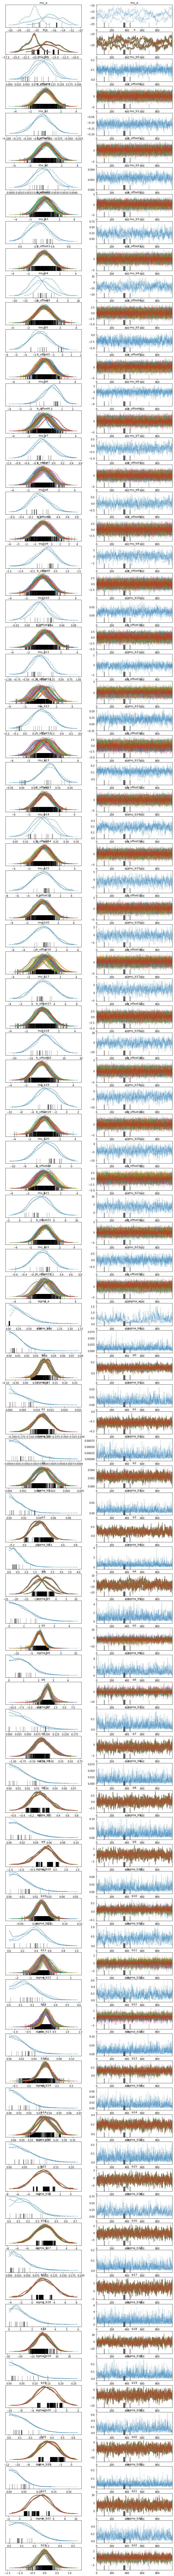

In [20]:
pm.plots.traceplot(hierarchical_trace_full_offset);

In [18]:
sum_hierarchical_season_offset = pm.summary(hierarchical_trace_full_offset)
sum_hierarchical_season_offset

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a         -18.333  2.874 -23.677  -13.490      0.839    0.609      13.0   
a[1988-1989] -18.321  2.892 -23.691  -13.295      0.833    0.604      13.0   
a[1989-1990] -18.338  2.906 -23.647  -13.322      0.844    0.612      13.0   
a[1990-1991] -18.292  2.897 -23.618  -13.295      0.831    0.602      13.0   
a[1991-1992] -18.323  2.907 -23.597  -13.303      0.840    0.609      13.0   
...              ...    ...     ...      ...        ...      ...       ...   
b22[29]        0.019  0.244  -0.452    0.462      0.007    0.005    1256.0   
b22[30]        0.070  0.254  -0.399    0.549      0.007    0.005    1191.0   
b22[31]        0.050  0.257  -0.428    0.519      0.007    0.005    1235.0   
b22[32]        0.044  0.251  -0.431    0.506      0.007    0.005    1261.0   
b22[33]        0.077  0.264  -0.430    0.572      0.008    0.005    1182.0   

              ess_tail  r_hat  
mu_a             151.0   1.25  
a[1988-1989]     182.0   1.24  
a[1989-1990]     165.0   1.25  
a[1990-1991]     156.0   1.24  
a[1991-1992]     157.0   1.24  
...                ...    ...  
b22[29]         1761.0   1.00  
b22[30]         2193.0   1.00  
b22[31]         2003.0   1.00  
b22[32]         2080.0   1.00  
b22[33]         1907.0   1.00  

[1646 rows x 9 columns]

In [19]:
sum_hierarchical_season_offset.sort_values('r_hat')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_offset22[16]   0.057  0.960  -1.747    1.862      0.022    0.016    1996.0   
b_offset22[15]   0.111  0.934  -1.649    1.794      0.022    0.016    1850.0   
b_offset22[14]  -0.259  0.961  -2.046    1.624      0.022    0.016    1963.0   
b_offset22[13]  -0.269  0.935  -2.031    1.445      0.023    0.016    1687.0   
b_offset22[12]  -0.204  0.899  -1.862    1.468      0.019    0.015    2165.0   
...                ...    ...     ...      ...        ...      ...       ...   
a[2012-2013]   -18.381  2.918 -23.525  -13.171      0.846    0.614      13.0   
a[2016-2017]   -18.412  2.915 -23.816  -13.354      0.847    0.614      13.0   
a[2021-2022]   -18.330  2.905 -23.677  -13.346      0.844    0.612      13.0   
a[1999-2000]   -18.372  2.898 -23.751  -13.374      0.840    0.609      13.0   
mu_a           -18.333  2.874 -23.677  -13.490      0.839    0.609      13.0   

                ess_tail  r_hat  
b_offset22[16]    2220.0   1.00  
b_offset22[15]    1906.0   1.00  
b_offset22[14]    2121.0   1.00  
b_offset22[13]    2176.0   1.00  
b_offset22[12]    2455.0   1.00  
...                  ...    ...  
a[2012-2013]       174.0   1.25  
a[2016-2017]       159.0   1.25  
a[2021-2022]       159.0   1.25  
a[1999-2000]       159.0   1.25  
mu_a               151.0   1.25  

[1646 rows x 9 columns]

Declustered Hierarchical Model

In [11]:
season_idxs, seasons = pd.factorize(unnested.year)
coords = {
    "season": seasons,
    "obs_id": np.arange(len(season_idxs)),
}
with pm.Model(coords=coords) as hierarchical_model:
    season_idx = pm.Data("season_idx", season_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10000)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)

    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="season")

    nba_est = a[season_idx]
    for i,col in enumerate(numeric_col):
        # Set mu for new predictor
        mu = pm.Normal("mu_b{}".format(i), mu=0.0, sigma=10000)
        # Set Sigma for new predictor
        sigma = pm.HalfNormal("sigma_b{}".format(i), 5.0)
        # Set beta for new predictor
        b_offset = pm.Normal('b_offset{}'.format(i), mu=0, sd=1, shape=len(np.unique(season_idxs)))
        b = pm.Deterministic("b{}".format(i), mu + b_offset * sigma)
        # Continous update of nba_est formula
        nba_est = nba_est + b[season_idx] * clean_df[col].values
    
    # Data likelihood
    nba_like = pm.Bernoulli(
        "nba_like",
        logit_p = nba_est,
        observed = clean_df.All_NBA_Boolean.astype(int).values
    )


In [12]:
with hierarchical_model:
    hierarchical_trace_denested_offset = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_offset22, sigma_b22, mu_b22, b_offset21, sigma_b21, mu_b21, b_offset20, sigma_b20, mu_b20, b_offset19, sigma_b19, mu_b19, b_offset18, sigma_b18, mu_b18, b_offset17, sigma_b17, mu_b17, b_offset16, sigma_b16, mu_b16, b_offset15, sigma_b15, mu_b15, b_offset14, sigma_b14, mu_b14, b_offset13, sigma_b13, mu_b13, b_offset12, sigma_b12, mu_b12, b_offset11, sigma_b11, mu_b11, b_offset10, sigma_b10, mu_b10, b_offset9, sigma_b9, mu_b9, b_offset8, sigma_b8, mu_b8, b_offset7, sigma_b7, mu_b7, b_offset6, sigma_b6, mu_b6, b_offset5, sigma_b5, mu_b5, b_offset4, sigma_b4, mu_b4, b_offset3, sigma_b3, mu_b3, b_offset2, sigma_b2, mu_b2, b_offset1, sigma_b1, mu_b1, b_offset0, sigma_b0, mu_b0, a, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24572 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9673770305896485, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9647722095075906, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or repara

/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_43646/3847910271.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.plots.traceplot(hierarchical_trace_denested_offset);


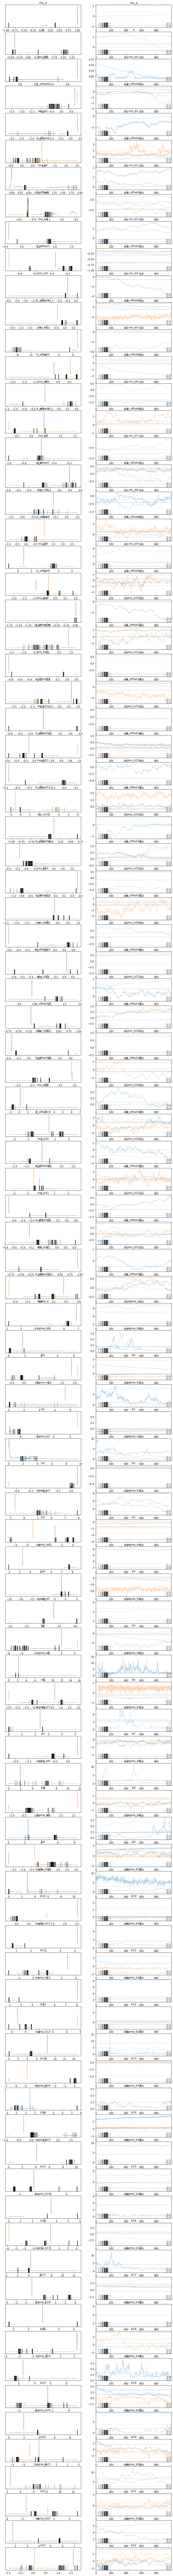

In [15]:
az.rcParams["plot.max_subplots"] = 200# This finishes without error
pm.plots.traceplot(hierarchical_trace_denested_offset);

In [21]:
sum_hierarchical_denested_offset = pm.summary(hierarchical_trace_denested_offset)
sum_hierarchical_denested_offset

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a          0.130  0.692  -0.913    0.999      0.345    0.264       4.0   
a[Pre]        0.421  0.607  -0.378    1.206      0.289    0.222       5.0   
a[Post]      -0.120  0.321  -0.471    0.365      0.160    0.122       4.0   
mu_b0         0.198  0.333  -0.106    0.723      0.163    0.126       5.0   
b_offset0[0]  0.165  0.405  -0.475    0.670      0.189    0.144       5.0   
...             ...    ...     ...      ...        ...      ...       ...   
b21[0]        0.612  2.617  -1.509    5.005      1.292    0.992       5.0   
b21[1]        0.668  1.187  -0.886    2.495      0.550    0.416       5.0   
sigma_b22     3.756  1.701   1.777    6.490      0.832    0.635       5.0   
b22[0]        0.678  0.947  -0.531    1.644      0.465    0.360       5.0   
b22[1]        0.731  0.689   0.035    1.738      0.338    0.260       5.0   

              ess_tail  r_hat  
mu_a              13.0   3.60  
a[Pre]            12.0   2.80  
a[Post]           13.0   3.19  
mu_b0             19.0   2.01  
b_offset0[0]      21.0   2.41  
...                ...    ...  
b21[0]            11.0   2.54  
b21[1]            15.0   2.31  
sigma_b22         14.0   2.63  
b22[0]            14.0   2.23  
b22[1]            12.0   2.35  

[142 rows x 9 columns]

In [22]:
sum_hierarchical_denested_offset.sort_values('r_hat')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b8         -0.325  0.161  -0.617    0.009      0.048    0.035      12.0   
b_offset20[1] -0.281  0.508  -1.127    0.931      0.098    0.072      12.0   
b19[0]         2.062  0.918   1.146    3.406      0.418    0.315       7.0   
b_offset8[1]   0.666  0.469  -0.274    1.510      0.156    0.114       9.0   
sigma_b21      5.495  2.188   2.438    8.834      0.921    0.688       6.0   
...              ...    ...     ...      ...        ...      ...       ...   
sigma_b5       3.105  0.743   1.966    4.061      0.370    0.283       4.0   
b15[1]         1.562  2.404  -0.784    5.393      1.196    0.917       4.0   
b15[0]        -0.019  2.061  -2.925    3.061      1.026    0.785       4.0   
b16[0]         0.883  2.177  -2.139    4.110      1.084    0.830       4.0   
b_offset16[0]  0.230  0.586  -0.775    0.708      0.292    0.223       4.0   

               ess_tail  r_hat  
mu_b8              20.0   1.26  
b_offset20[1]      24.0   1.39  
b19[0]             24.0   1.62  
b_offset8[1]       17.0   1.66  
sigma_b21          17.0   1.70  
...                 ...    ...  
sigma_b5           11.0   3.85  
b15[1]             11.0   3.94  
b15[0]             11.0   4.04  
b16[0]             12.0   4.15  
b_offset16[0]      12.0   4.22  

[142 rows x 9 columns]